# Zoomcamp ML learning wk2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [1]:
#load data
#wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
!curl -O https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  5  291k    5 15479    0     0  19837      0  0:00:15 --:--:--  0:00:15 19947
100  291k  100  291k    0     0   331k      0 --:--:-- --:--:-- --:--:--  333k


In [182]:
df = pd.read_csv('laptops.csv')

In [183]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   laptop        2160 non-null   object 
 1   status        2160 non-null   object 
 2   brand         2160 non-null   object 
 3   model         2160 non-null   object 
 4   cpu           2160 non-null   object 
 5   ram           2160 non-null   int64  
 6   storage       2160 non-null   int64  
 7   storage_type  2118 non-null   object 
 8   gpu           789 non-null    object 
 9   screen        2156 non-null   float64
 10  touch         2160 non-null   object 
 11  final_price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


## Exploratory data analysis

In [184]:
df['final_price'].describe()

count    2160.000000
mean     1312.638509
std       911.475417
min       201.050000
25%       661.082500
50%      1031.945000
75%      1708.970000
max      7150.470000
Name: final_price, dtype: float64

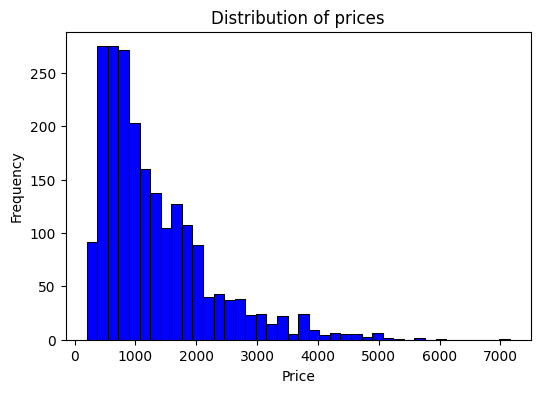

In [185]:
plt.figure(figsize=(6, 4))

sns.histplot(df['final_price'], bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [186]:
df[ df['final_price'] > 6000].head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
1099,MSI Raider GE78HX 13VH-065ES Intel Core i9-139...,New,MSI,Raider,Intel Core i9,32,2000,SSD,RTX 4080,17.0,No,7150.47


In [187]:
#remove long tail
df = df[ df['final_price'] <= 6000]

In [188]:
col_subset = ['ram','storage','screen','final_price']
df = df[col_subset]

In [189]:
df.head()


,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


# Question 1
There's one feature with missing values. What is it?

In [190]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

screen has 4 missing values

# Question 2
What's the median (50% percentile) for variable 'ram'?

In [191]:
df['ram'].describe()

count    2159.000000
mean       15.406207
std         9.863638
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

median (50% percentile) for variable 'ram' : 16

# Prepare and split the dataset
```
Shuffle the dataset (the filtered one you created above), use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.

```

In [192]:
df = df.reset_index(drop=True)
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [193]:
np.random.seed(42)
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
df_shuffled = df_shuffled.reset_index(drop=True)

In [194]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [195]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

#y_train = np.log1p(df_train.final_price.values)
#y_val = np.log1p(df_val.final_price.values)
#y_test = np.log1p(df_test.final_price.values)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values


del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [197]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ram      1297 non-null   int64  
 1   storage  1297 non-null   int64  
 2   screen   1294 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 30.5 KB


# Question 3
```
We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.
Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!
Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?
```

In [199]:
screen_mean = int(df_train['screen'].mean())


In [200]:
df_train_m = df_train.copy()
df_train_m['screen'] = df_train_m['screen'].fillna(screen_mean)


In [201]:
df_train_z = df_train.copy()
#df_train_z['ram'] = df_train_z['ram'].fillna(0)
#df_train_z['storage'] = df_train_z['storage'].fillna(0)
df_train_z['screen'] = df_train_z['screen'].fillna(0.0)

In [202]:
df_train_z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ram      1297 non-null   int64  
 1   storage  1297 non-null   int64  
 2   screen   1297 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 30.5 KB


In [203]:
X_train_m = df_train_m.values
X_train_z = df_train_z.values

In [204]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [205]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [206]:
w_0_m, w_m = train_linear_regression_reg(X_train_m, y_train)
y_predict_m = w_0_m + X_train_m.dot(w_m)
y_predict_m

array([2355.61808856,  409.29816937, 2404.14351253, ..., 1305.62680431,
       2343.48673257, 1257.10138034])

In [207]:
rmse_m = round(rmse(y_train, y_predict_m), 2)
rmse_m

np.float64(597.46)

In [208]:
w_0_z, w_z = train_linear_regression_reg(X_train_z, y_train)
y_predict_z = w_0_z + X_train_z.dot(w_z)
y_predict_z

array([2353.83021543,  406.14897439, 2394.6384241 , ..., 1299.35897576,
       2343.62816326, 1258.5507671 ])

In [209]:
rmse_z = round(rmse(y_train, y_predict_z),2)
rmse_z

np.float64(597.46)

In [210]:
print('RMSE, mean filling',  rmse_m)
print('RMSE, zero filling', rmse_z)

RMSE, mean filling 597.46
RMSE, zero filling 597.46


Q3 answer:  fill missing values with mean or zero gives the same RMSE

# Question 4
```
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.
```

In [165]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

In [211]:
X_valid = df_val.fillna(0).values

for r in r_list:
    w_0, w = train_linear_regression_reg(X_train_z, y_train, r)
    y_predict_val = w_0 + X_valid.dot(w)
    valid_rmse = round(rmse(y_val, y_predict_val), 2)
    #print(y_predict_val)
    print(r,valid_rmse) 
    
    
    

0 572.11
0.01 572.11
0.1 572.12
1 572.27
5 572.85
10 573.4
100 575.3


R(0, 0.01) gave teh same RMSE of 572.11. Select the lowest r = 0

# Question 5

```
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))
```

In [212]:
def suffle_df(df, seed):
    
    np.random.seed(seed)
    n = len(df)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    
    return df_shuffled

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2159 non-null   int64  
 1   storage      2159 non-null   int64  
 2   screen       2155 non-null   float64
 3   final_price  2159 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


In [214]:


def train_seeds(df, seeds):
    rmse_list  = np.array([])
    for seed in seeds:
        
        df_shuffled = suffle_df(df, seed)
        df_shuffled = df_shuffled.reset_index(drop=True)
        
        n = len(df_shuffled)
        
        n_val = int(0.2 * n)
        n_test = int(0.2 * n)
        n_train = n - (n_val + n_test)
        
        df_train = df_shuffled.iloc[:n_train].copy()
        df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
        df_test = df_shuffled.iloc[n_train+n_val:].copy()
          
        #y_train = np.log1p(df_train.final_price.values)
        #y_val = np.log1p(df_val.final_price.values)
        #y_test = np.log1p(df_test.final_price.values)
        y_train = df_train.final_price.values
        y_val = df_val.final_price.values


        del df_train['final_price']
        del df_val['final_price']
        del df_test['final_price']
    

        df_train['screen'] = df_train['screen'].fillna(0.0)
        X_train = df_train.values
        
        df_val['screen'] = df_val['screen'].fillna(0.0)
        X_val = df_val.values
        
        w_0, w = train_linear_regression_reg(X_train, y_train)
    
        y_predict_val = w_0 + X_val.dot(w)
        val_rmse = rmse(y_val, y_predict_val)
        
        
        rmse_list = np.append(rmse_list, val_rmse)

    return rmse_list


In [215]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_list = train_seeds(df, seeds)
rmse_list

array([582.27158534, 629.36771227, 637.63658878, 632.36147657,
       573.22704045, 622.88931554, 656.78481162, 516.80521688,
       649.91298975, 549.36565545])

In [216]:
rmse_list_std = round(np.std(rmse_list), 3)
print(' STD of RMSE Scores = {}'.format(rmse_list_std))


 STD of RMSE Scores = 44.526


# Question 6
```
Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?
```

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2159 non-null   int64  
 1   storage      2159 non-null   int64  
 2   screen       2155 non-null   float64
 3   final_price  2159 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


In [218]:
df_shuffled = suffle_df(df, 9).copy()
df_shuffled = df_shuffled.reset_index(drop=True)
n = len(df_shuffled)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test_c = df_shuffled.iloc[n_train+n_val:].copy()


df_train_combined = pd.concat([df_train, df_val])
df_train_combined = df_train_combined.reset_index(drop=True)

#y_train_combined = np.log1p(df_train_combined.final_price.values)
y_train_combined = df_train_combined.final_price.values
del df_train_combined['final_price']


df_train_combined['screen'] = df_train_combined['screen'].fillna(0.0)
X_train_combined = df_train_combined.values

#y_test_c = np.log1p(df_test_c.final_price.values)
y_test_c = df_test_c.final_price.values
del df_test_c['final_price']


df_test_c['screen'] = df_test_c['screen'].fillna(0.0)
X_test = df_test_c.values

w_0, w = train_linear_regression_reg(X_train_combined, y_train_combined, 0.001)
        
y_predict_test = w_0 + X_test.dot(w)
test_rmse = rmse(y_test_c, y_predict_test)

round(test_rmse,2)


np.float64(607.01)

In [221]:
print('Q6 test RMSE: ', round(test_rmse, 2))

Q6 test RMSE:  607.01
